In [123]:
import cv2
import matplotlib.pyplot as plt
import re
from pytesseract import *
from deskew import determine_skew
import math
from typing import Tuple, Union
import numpy as np
import os
pytesseract.tesseract_cmd = R'C:\Program Files\Tesseract-OCR\tesseract.exe'

def YOLO_to_img(path):              # 이미지 받고 읽기
    img = cv2.imread(f"{path}",cv2.IMREAD_COLOR)
    return img



def text_replace(text):             # tesseract를 통해 나온 text 정규화
    #text = text.replace("\n", "")
    text = text.replace("\x0c", "")
    text = text.replace(",", "")
    text = text.replace(".", "")
    return text


def _rotate(image, angle, background):  # 화면 돌리기 함수
        
        old_width, old_height = image.shape[:2]
        angle_radian = math.radians(angle)
        width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
        height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        rot_mat[1, 2] += (width - old_width) / 2
        rot_mat[0, 2] += (height - old_height) / 2
        return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=(255,255,255))


def rotate_img(img):                    # 화면 돌리기 후 grayscale
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    angle = determine_skew(grayscale)
    rotated = _rotate(img, angle, (0, 0, 0))
    rotated_gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    return rotated_gray

# ----------------------------------------------------------------
# 이미지 자르기는 들어오는 YOLO 이미지에 따라 달라질 수 있음

def YOLO1_img(img):           # YOLO2 이미지 자르기, (당월부과액, 할인총계)
    new_YOLO1_img = img[26:,:300]
    return new_YOLO1_img

def YOLO2_img(img):           # YOLO2 이미지 자르기 (할인총계,납기일,미납연체료)
    new_YOLO2_img = img[125:180,340:]
    return new_YOLO2_img

def YOLO3_img(img):                # YOLO3 이미지 자르기, (납기일, 총 납기금액)
    new_YOLO3_img = img[220:250,300:430]
    return new_YOLO3_img


# ----------------------------------------------------------------------------------


def tesseract_text(img):           # tesseract한 결과
    text = pytesseract.image_to_string(img, lang ="kor")
    return text

def YOLO1_price(YOLO1_list):    # YOLO1의 정보  demo를 위해서 numbers가 ['1', '2023', '1', '2023', '2', '28', '172980']이렇게 온다고 가정
    day = ['년', '월 분 고지서 내역 입니다. ', '년', '월', '일까지 ' , '원 납부해주셔야 합니다']

    if len(YOLO1_list) == len(day):

        combined = []
        for i in range(len(YOLO1_list)):
            combined.append (YOLO1_list[i]+day[i])
        result = ' '.join(combined)
    else:
        result = "인식에 실패하였습니다."
    return result

def YOLO2_price(YOLO2_list):    # 할인총계만 있다면 len = 1, 미납액 까지 있다면 3
    return_str = ""
    if len(YOLO2_list) == 1:
        discount_price = YOLO2_list[0] # 할인총계
        return_str = f"할인총계는 {discount_price}입니다."
    elif len(YOLO2_list) == 3:
        discount_price = YOLO2_list[0] # 할인총계
        dismiss = YOLO2_list[1] # 미납액
        add_price = YOLO2_list[2] # 미납연체료
        return_str = f"할인총계은 {discount_price}원 미납액은 {dismiss}원  미납연체료는 {add_price}원입니다."
    elif len(YOLO2_list) == 0:
        return_str = f"할인총계 미납액 미납연체료가 없습니다."
    else:
        return_str = "인식에 실패했습니다."
    return return_str


def str_to_int(text):   # string값에서 숫자뽑아서 넣기. 0으로 시작하는 것 없애줌
    numbers = re. findall('\d+', text)
    new_numbers = []
    for number in numbers:
        if len(number) == 1: # 한 자리수일땐 패스
            new_numbers.append(number)
        else:   # 두 자리수 이상일 때
            if number[0] == "0":    # 첫 번째 숫자가 0으로 시작하면
                number = number[1:]
                new_numbers.append(number)
            else:
                new_numbers.append(number)
    return new_numbers


def final_announce(int_list):
    announce = ['원 납부해주셔야 합니다']
    return_str = ""
    combined = []
    if len(int_list) == len(announce):
        for i in range(len(int_list)):
            combined.append(int_list[i]+announce[i])
        return_str = ' '.join(combined)
    else:
        return_str = "인식에 실패했습니다."
    return return_str

# ---------------------------------- 실제 -------------------------------------------
YOLO1_real_text = tesseract_text(YOLO1_img(YOLO_to_img("./runs/detect/photo/pic.jpg")))
YOLO2_real_text = tesseract_text(YOLO2_img(YOLO_to_img("./runs/detect/photo/pic3.jpg")))
YOLO3_real_text = tesseract_text(YOLO3_img(YOLO_to_img("./runs/detect/photo/pic3.jpg")))
# 실질적으로 들어갈 때 경로 설정해주어서 text_replace함수에 인자값으로 들어갈 값들

# ---------------------------------- 예시 -------------------------------------------
#YOLO2_text_1 = "33221"                        # 할인총계만 있다고 가정
#YOLO2_text_2 = "33221   1231   14124"         # 할인총계, 미납액,미납연체료 다 있다고 가정
#YOLO3_text = '납개 2022년 8월01일\n        113,350\n\x0c'
#
#YOLO2_fail = "33221   1231"

# 이미지를 받아서 자르는 과정을 하고 tesseract를 돌린고 난 후라고 가정
# norm_YOLO2_1 = str_to_int(text_replace(YOLO2_text_1))   # YOLO2 정규화 후 숫자만 남기기
# norm_YOLO2_2 = str_to_int(text_replace(YOLO2_text_2))   # YOLO2 정규화 후 숫자만 남기기
# norm_YOLO3 = str_to_int(text_replace(YOLO3_text))   # YOLO3 정규화 후 숫자만 남기기

# orm_YOLO2_fail = str_to_int(text_replace(YOLO2_fail))   # YOLO2 정규화 후 숫자만 남기기

# Yolo1 결과값 출력
# YOLO1_result = YOLO1_price(YOLO1_real_text)

# YOLO2 결과값 출력
# YOLO2_result_1 = YOLO2_price(norm_YOLO2_1)   # 할인총계
# # print(YOLO2_result_1)
# YOLO2_result_2 = YOLO2_price(norm_YOLO2_2)   # 할인총계,미납액,미납연체료
# # print(YOLO2_result_2)


# YOLO2_result_fail = YOLO2_price(norm_YOLO2_fail)   # 미납액,미납연체료
# #print(YOLO2_result_fail)

# # YOLO3 결과값 출력
# result = final_announce(norm_YOLO3)       # 최종 납기일, 납기금액
# # print(result)

# -------------------------------- 실제 demo 버전용----------------------------------------
norm_YOLO1_real = str_to_int(text_replace(YOLO1_real_text))
norm_YOLO2_real = str_to_int(text_replace(YOLO2_real_text)) # YOLO2 정규화 후 숫자만 남기기
norm_YOLO3_real = str_to_int(text_replace(YOLO3_real_text))   # YOLO3 정규화 후 숫자만 남기기

YOLO1_result = YOLO1_price(norm_YOLO1_real)
YOLO2_result = YOLO2_price(norm_YOLO2_real)
YOLO3_result = final_announce(norm_YOLO3_real) 

final_list = []
final_list.extend([YOLO1_result,YOLO2_result,YOLO3_result])
# ----------------------------------------------------------------------------------------


In [124]:
final_list

['2021년 1월 분 고지서 내역 입니다.  2021년 2월 22일까지  152440원 납부해주셔야 합니다',
 '할인총계는 3000입니다.',
 '152440원 납부해주셔야 합니다']

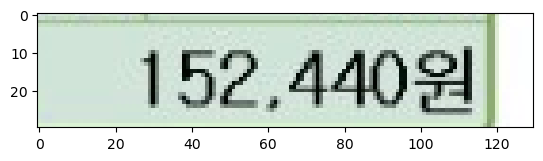

In [113]:
plt.imshow(YOLO3_img(YOLO_to_img("./runs/detect/photo/pic3.jpg")))#YOLO3_img

In [116]:
a = tesseract_text(YOLO3_img(YOLO_to_img("./runs/detect/photo/pic3.jpg")))
a

'152.440원\n'

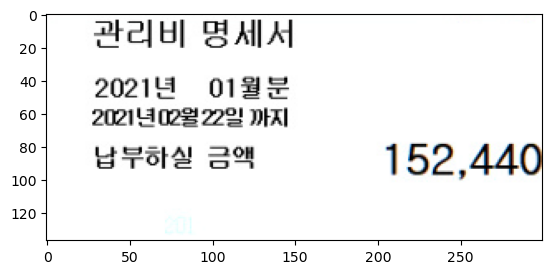

In [105]:
plt.imshow(YOLO1_img(YOLO_to_img("./runs/detect/photo/pic.jpg"))) #YOLO1_img

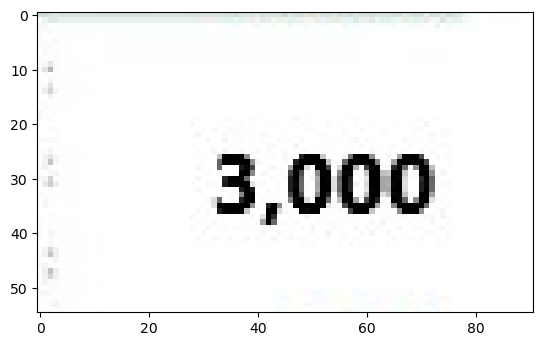

In [104]:
plt.imshow(YOLO2_img(YOLO_to_img("./runs/detect/photo/pic3.jpg")))

In [102]:
abs = tesseract_text(YOLO2_img(YOLO_to_img("./runs/detect/photo/pic3.jpg")))
abs

'3,000\n'

In [73]:
len(norm_YOLO1_real)

6

In [74]:
final_list

['20232년 2023월 분 고지서 내역 입니다.  2년 28월 172980일까지  10원 납부해주셔야 합니다',
 '할인총계 미납액 미납연체료가 없습니다.',
 '인식에 실패했습니다.']

In [65]:
norm_YOLO1_real

['20232', '2023', '2', '28', '172980', '10']

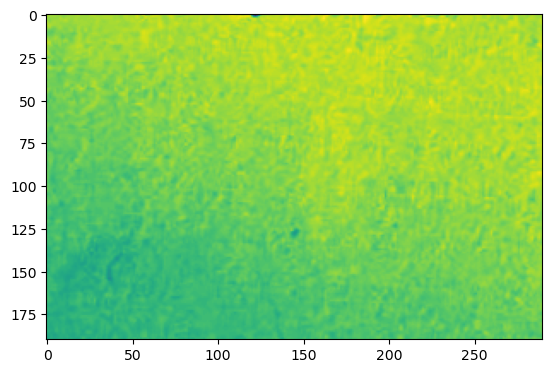

In [39]:
plt.imshow(YOLO2_img(rotate_img(YOLO_to_img("./runs/detect27/photo/web3.jpg"))))

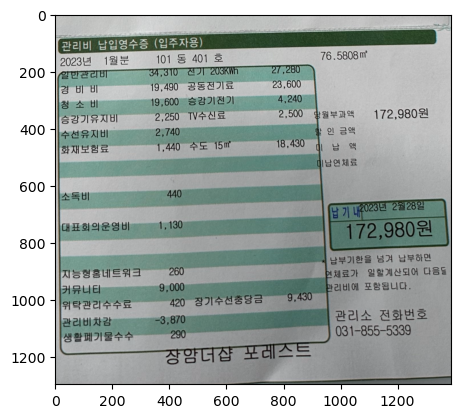

In [35]:
plt.imshow(YOLO_to_img("./runs/detect27/photo/web3.jpg"))

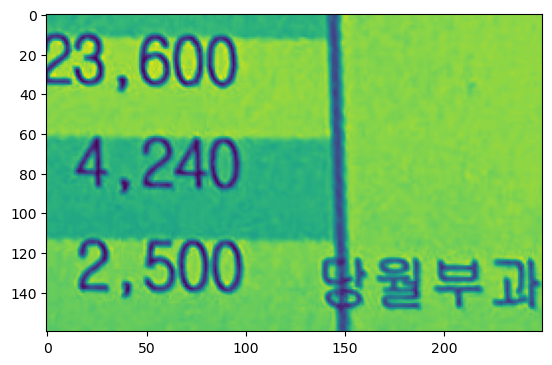

In [34]:
plt.imshow(YOLO2_img(rotate_img(YOLO_to_img("./runs/detect27/photo/web3.jpg"))))

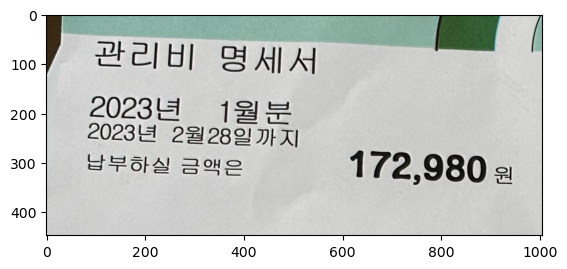

In [22]:
plt.imshow(YOLO_to_img("./runs/detect27/photo/web2.jpg"))

In [28]:
def _rotate(image, angle, background):  # 화면 돌리기 함수
        
        old_width, old_height = image.shape[:2]
        angle_radian = math.radians(angle)
        width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
        height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

        image_center = tuple(np.array(image.shape[1::-1]) / 2)
        rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
        rot_mat[1, 2] += (width - old_width) / 2
        rot_mat[0, 2] += (height - old_height) / 2
        return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=(255,255,255))


def rotate_img(img):                    # 화면 돌리기 후 grayscale
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    angle = determine_skew(grayscale)
    rotated = _rotate(img, angle, (0, 0, 0))
    rotated_gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    return rotated_gray

In [31]:
img = cv2.cvtColor("./runs/detect27/photo/web2.jpg")
plt.imshow(determine_skew(img))

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - cvtColor() missing required argument 'code' (pos 2)
>  - cvtColor() missing required argument 'code' (pos 2)


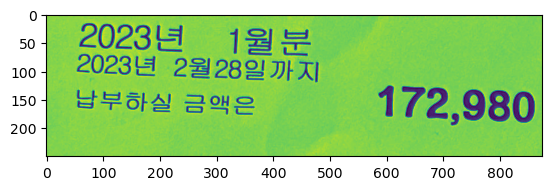

In [53]:
plt.imshow(rotate_img(YOLO1_img(YOLO_to_img("./runs/detect27/photo/web2.jpg"))))

In [54]:
YOLO1_real_text

'20232,\n2023년 2월28일까지\n\n남부하실 금액은          172,.980\n\n10\n'

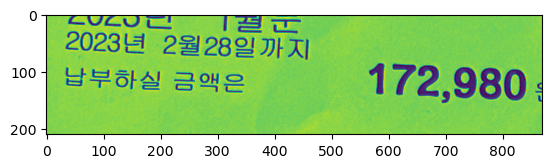

In [17]:
plt.imshow(YOLO1_img(rotate_img(YOLO_to_img("./runs/detect27/photo/web2.jpg"))))

'20232,\n2023년 2월28일까지\n\n남부하실 금액은          172,.980\n\n10\n'

In [32]:
YOLO2_real_text

'23,600\n4240\n2.500 발월부괴\n'

In [5]:
final_list

['2023년 2023월 분 고지서 내역 입니다.  2년 28월 172일까지  980원 납부해주셔야 합니다',
 '인식에 실패했습니다.',
 '인식에 실패했습니다.']

In [10]:
abs = cv2.imread("./runs/detect27/photo/web2.jpg")

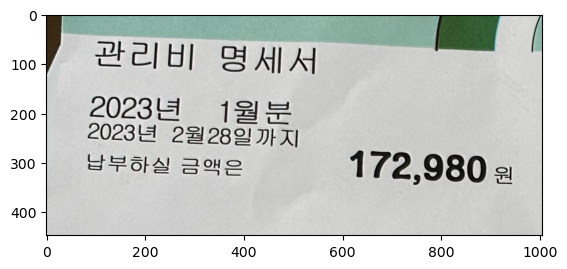

In [11]:
plt.imshow(abs)

In [2]:
!pip install deskew


  Using cached deskew-1.4.2-py3-none-any.whl (7.6 kB)
